In [14]:
import os
import sys
# Replace 'packagename' with the name of your package
module_path = os.path.join(os.path.dirname(sys.executable), 'lib', 'site-packages', 'sklearn')
os.path.exists(module_path)






!{sys.executable} -m pip install scikit-learn

     |████████████████████████████████| 11.1 MB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 6.3 MB/s eta 0:00:01


In [94]:


import os
import sys
sys.path.append("home/jussi.hakosalo/Indica/tests/integration")
from indica.bayesmodels import BayesModels, uniform
from indica.models.plasma import example_run
from indica.models.helike_spectroscopy import Helike_spectroscopy

from tests.integration.models.test_helike_spectroscopy import helike_LOS_example

import flatdict
import numpy as np
import emcee
import sklearn
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, MinMaxScaler


import matplotlib.pyplot as plt

In [95]:
blob=[]
class TestBasisBayesModels():

    def setup_class(self):
        self.plasma = example_run()
        self.plasma.time_to_calculate = self.plasma.t[1]
        self.los_transform = helike_LOS_example(nchannels=1)
        self.los_transform.set_equilibrium(self.plasma.equilibrium)

    def test_simple_run_bayesmodels_with_xrcs(self):
        xrcs = Helike_spectroscopy(name="xrcs", )
        xrcs.plasma = self.plasma
        xrcs.set_los_transform(self.los_transform)

        priors = {
            "Te_prof_y0": lambda x: uniform(x, 500, 5e4),
            "Te_prof_peaking": lambda x: uniform(x, 1, 30),
            "Ti_prof_y0": lambda x: uniform(x, 500, 5e4),
            "Ti_prof_peaking": lambda x: uniform(x, 1, 30),
            "Te_prof_wped": lambda x: uniform(x,0.2,5)
        }

        bckc = {}
        bckc = dict(bckc, **{xrcs.name: {**xrcs(calc_spectra=False)}})
        flat_phantom_data = flatdict.FlatDict(bckc, delimiter=".")

        bm = BayesModels(
            plasma=self.plasma,
            data=flat_phantom_data,
            diagnostic_models=[xrcs],
            quant_to_optimise=["xrcs.ti_w", "xrcs.te_kw"],
            priors=priors,
        )


        # Setup Optimiser
        params_names = [
            "Te_prof.y0",
            "Te_prof.y1",
            "Te_prof.peaking",
            "Te_prof.wped",
            "Te_prof.yend",
            "Te_prof.wcenter"
        ]

        #with cProfile.Profile() as pr:
        for i in range(200):
            Te_y0 = np.random.uniform(1000, 5000)
            Te_y1 = np.random.uniform(30, 70)
            Te_peaking = np.random.uniform(1,5)
            Te_wped = np.random.uniform(1,5)
            Te_yend = np.random.uniform(1,10)
            Te_wcenter = np.random.uniform(0.2,0.5)
            post, blobb=bm.ln_posterior({params_names[0]:Te_y0,params_names[1]:Te_y1,params_names[2]:Te_peaking,params_names[3]:Te_wped, params_names[4]:Te_yend, params_names[5]:Te_wcenter})
            global blob
            blob.append(blobb)
        



        




In [96]:

from indica.profiles_gauss import Profiles
p=Profiles()
p()

<xarray.DataArray 'electron_temperature' (rho_poloidal: 30)>
array([3000.        , 2992.91966974, 2972.1695657 , 2938.48601797, 2892.60535666, 2835.27822542,
       2767.72969199, 2691.75747031, 2609.17914625, 2521.57332352, 2430.32072235, 2336.64435177,
       2241.35995975, 2145.11734006, 2048.0870177 , 1950.2288311 , 1851.14555458, 1750.26156239,
       1646.7578475 , 1539.72403852, 1428.1804693 , 1311.02384004, 1187.06487813, 1055.70389561,
        915.90638421,  764.55334861,  605.11060745,  439.54769576,  236.37073427,   53.48828757])
Coordinates:
  * rho_poloidal  (rho_poloidal) float64 0.0 0.03448 0.06897 ... 0.9655 1.0
Attributes:
    datatype:  ('temperature', 'electron')

In [97]:
ta= TestBasisBayesModels()
ta.setup_class()

In [98]:
ta.test_simple_run_bayesmodels_with_xrcs()

Text(0.5, 1.0, 'Visualizing some profiles')

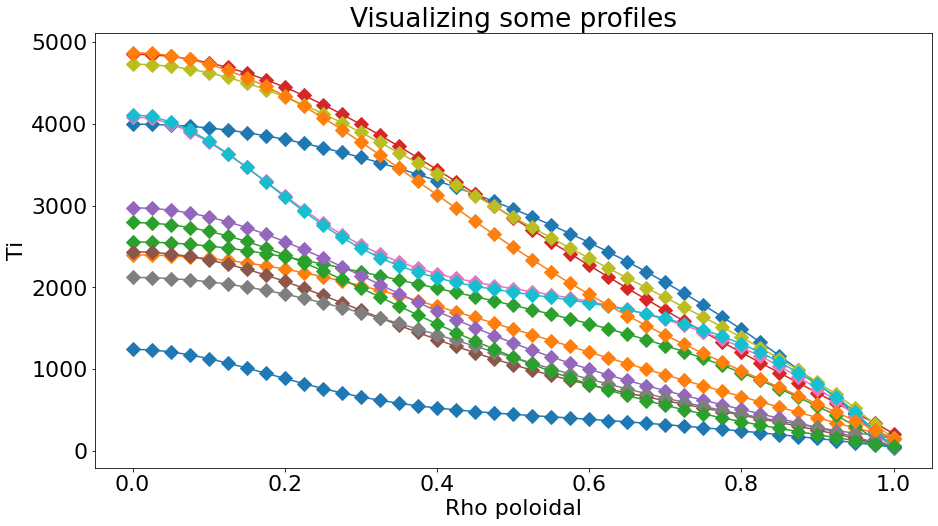

In [166]:
plt.rcParams['figure.figsize']=[15,8]
plt.rcParams.update({'font.size':22})


for item in blob[::16]:
    plt.plot(item["electron_temperature"].rho_poloidal,item["electron_temperature"],marker="D",markersize=10)

plt.xlabel("Rho poloidal")
plt.ylabel("Ti")

plt.title("Visualizing some profiles")

In [114]:

og_profiles=np.zeros(shape=(200,len(blob[0]["electron_temperature"])))
for i in range(200):
    og_profiles[i]=blob[i]["electron_temperature"]

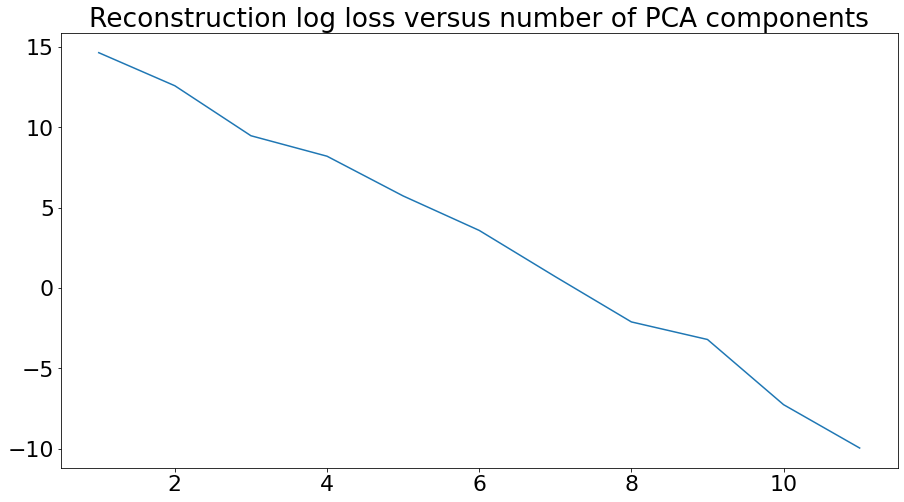

In [153]:



profiles=np.zeros(shape=(200,len(blob[0]["electron_temperature"])))

#Fix this?
#print(profiles.shape)
for i in range(200):
    profiles[i]=blob[i]["electron_temperature"]

    

#profiles=StandardScaler().fit_transform(profiles)
#profiles=MinMaxScaler().fit_transform(profiles)


losses=[]
percentage_accuracy=[]

for comp in range (1,12):
    #PCA 
    pca=PCA(n_components=comp)
    pca.fit(profiles)

    #Transform to calculate loadings
    pca_profiles=pca.transform(profiles)
    #print(pca_profiles.shape)


    #Invert the transformation
    projected_profiles=pca.inverse_transform(pca_profiles)


    #print(f"Loadings: {pca.components_}")
    #print(f"Explained variance: {pca.explained_variance_}")

    #Calculate loss
    loss = np.log(np.sum((profiles - projected_profiles) ** 2, axis=1).mean())
    variance_retained = np.sum(pca.explained_variance_ratio_) * 100
    losses.append(loss)
    percentage_accuracy.append(variance_retained)


#print(list(range(3,12)))
#print(losses)

plt.plot(list(range(1,12)),losses)
#plt.yscale("log")
plt.title("Reconstruction log loss versus number of PCA components")
plt.show()


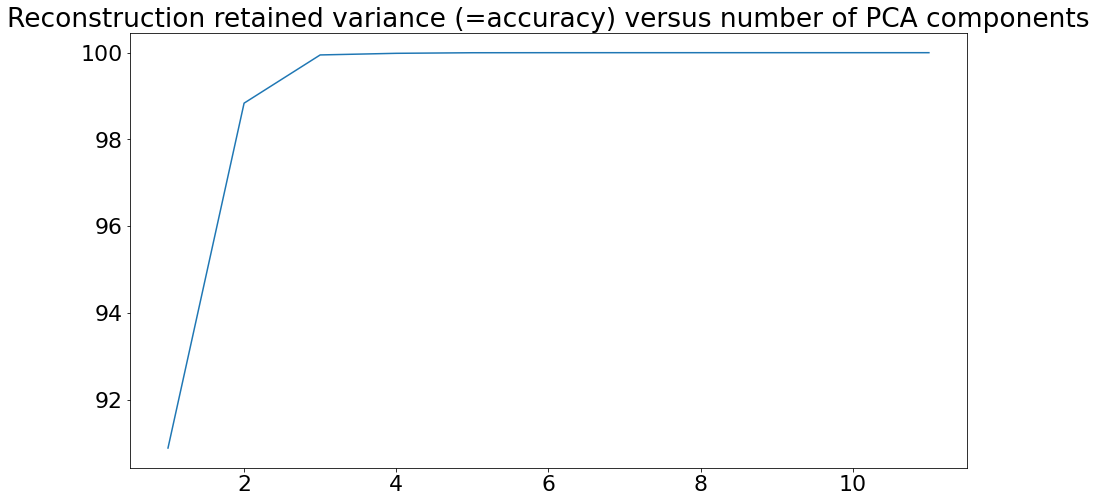

In [154]:
plt.plot(list(range(1,12)),percentage_accuracy)
plt.title("Reconstruction retained variance (=accuracy) versus number of PCA components")
plt.show()

In [167]:
pca=PCA(n_components=2)
pca.fit(profiles)

pca_profiles=pca.transform(profiles)
#print(pca_profiles.shape)


#Invert the transformation
projected_profiles=pca.inverse_transform(pca_profiles)

[22926114.74571678  2006330.48284533]


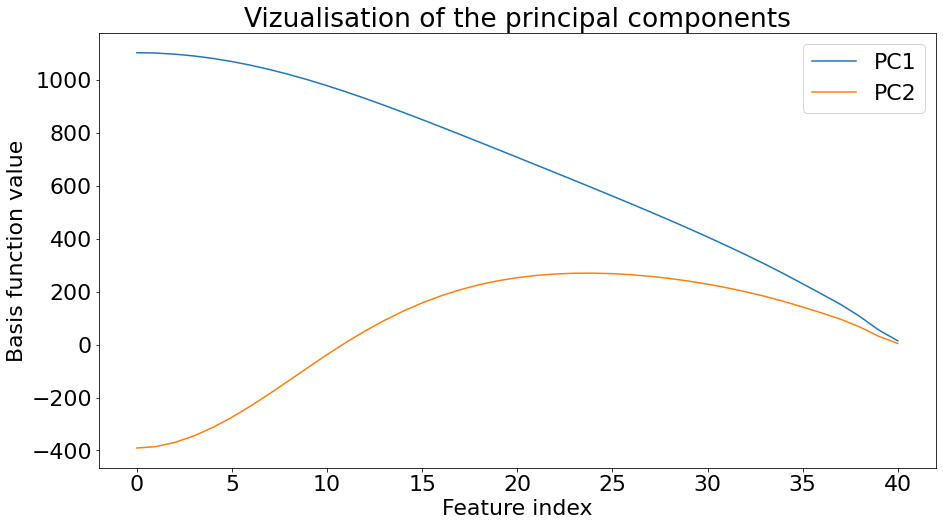

In [168]:
# Extract the loadings
loadings = pca.components_

# Extract the eigenvalues
eigenvalues = pca.explained_variance_

print(eigenvalues)

# Compute the basis functions
basis_functions = np.multiply(np.sqrt(eigenvalues[:, np.newaxis]), loadings)

# Plot the basis functions as lines
plt.plot(basis_functions.T)

# Add axis labels and a legend
plt.xlabel('Feature index')
plt.ylabel('Basis function value')
plt.legend(['PC{}'.format(i+1) for i in range(basis_functions.shape[0])])

plt.title("Vizualisation of the principal components")

# Show the plot
plt.show()


In [169]:
from sklearn.metrics import mean_squared_error

print(f"Recostruction MSE: {mean_squared_error(profiles,projected_profiles)}")

relative_error_percentage = (mean_squared_error(profiles,projected_profiles) / np.var(profiles)) * 100
print(relative_error_percentage)



variance_retained = np.sum(pca.explained_variance_ratio_) * 100
print(f"Percentage of variance retained: {variance_retained:.4f}%")


Recostruction MSE: 7125.317534102289
0.5009974170124905
Percentage of variance retained: 98.8361%


Text(0.5, 1.0, 'Reconstruction variance retention accuracy: 98.8361%, using 2 principal components')

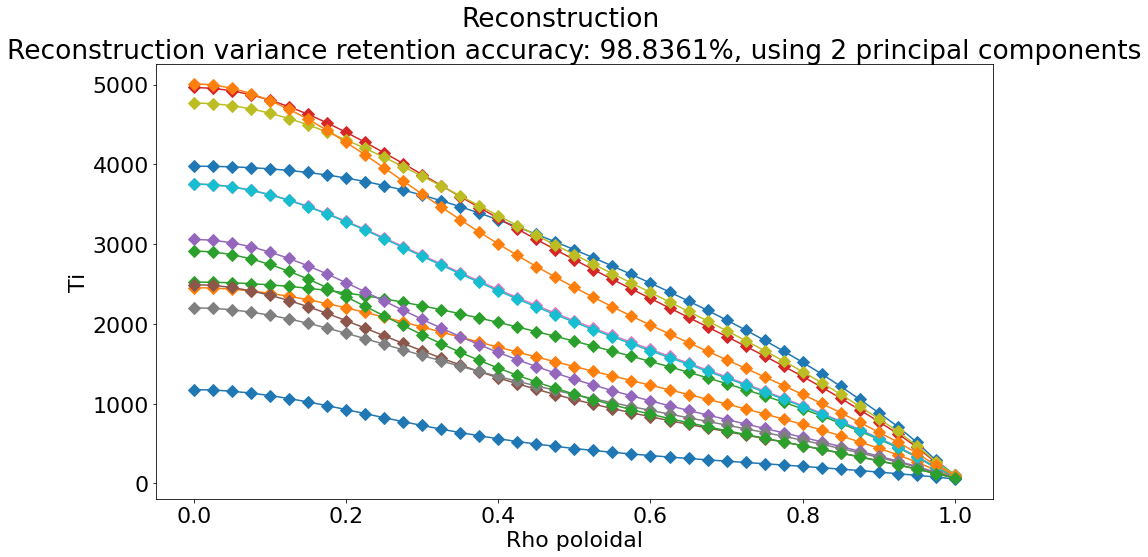

In [171]:
rho_poloidals=[]
#Draw the reconstruction
for i in range(0,len(blob),16):
    plt.plot(blob[i]["electron_temperature"].rho_poloidal,projected_profiles[i],marker="D",markersize=8)
    if len(rho_poloidals)<1:
        rho_poloidals=blob[i]["electron_temperature"].rho_poloidal

plt.xlabel("Rho poloidal")
plt.ylabel("Ti")
plt.suptitle("Reconstruction")
plt.title(f"Reconstruction variance retention accuracy: {variance_retained:.4f}%, using 2 principal components")

Text(0, 0.5, 'Ti')

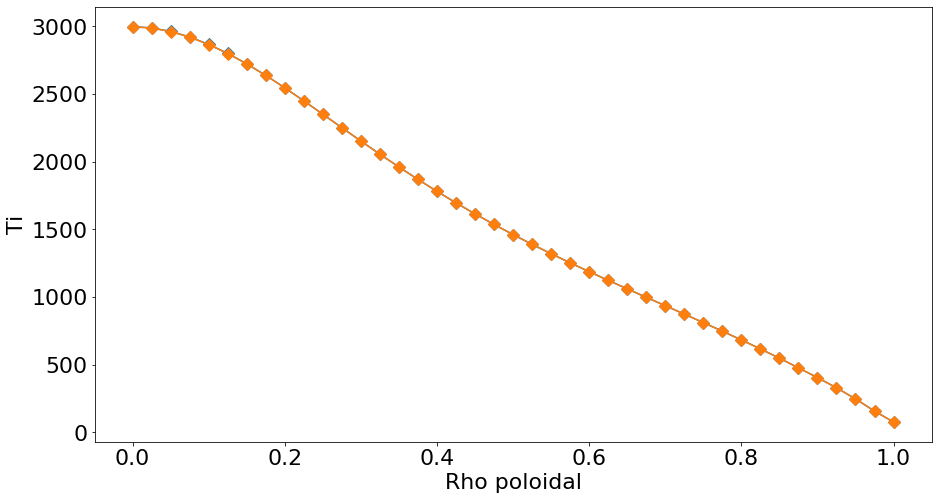

In [172]:
num_generated_points = 2
random_coefficients = np.random.randn(num_generated_points, pca.n_components_)

# Use coefficients and principal components to generate new data points
generated_points = np.dot(random_coefficients, pca.components_) + pca.mean_

# Print or visualize the generated points
for item in generated_points:
    #print(item)
    plt.plot(rho_poloidals,item,marker="D",markersize=8)

plt.xlabel("Rho poloidal")
plt.ylabel("Ti")

Text(0.5, 1.0, 'Generated profiles from the principal components')

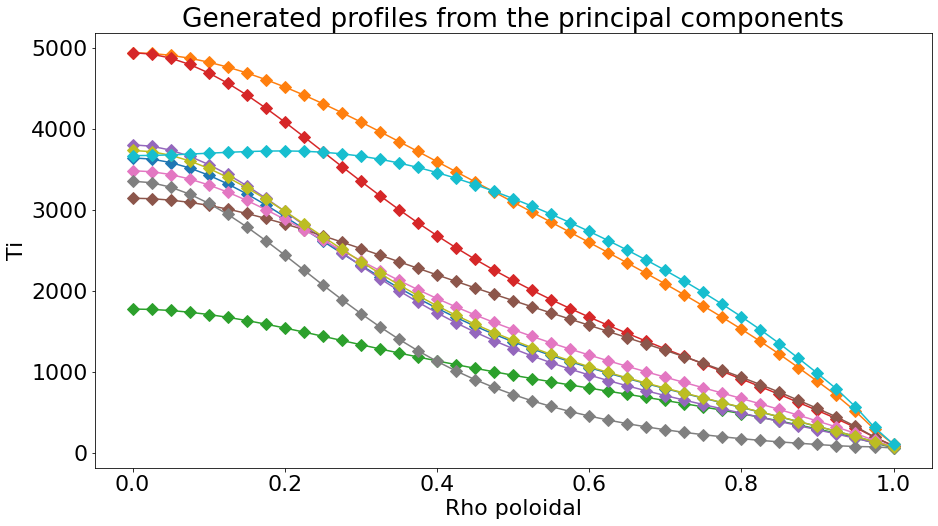

In [173]:
# Get the square roots of the eigenvalues (principal values)
principal_values = np.sqrt(pca.explained_variance_)

# Generate random coefficients for the principal components
num_generated_points = 10

# Scale the random coefficients by the principal values 
scaled_random_coefficients = np.random.randn(num_generated_points, pca.n_components_) * principal_values

#np.zeros((1,pca.n_components_))

# Use coefficients and principal components to generate new data points
generated_points = np.dot(scaled_random_coefficients, pca.components_) + pca.mean_



for item in generated_points:
    #print(item)
    plt.plot(rho_poloidals,item,marker="D",markersize=8)

plt.xlabel("Rho poloidal")
plt.ylabel("Ti")
plt.title("Generated profiles from the principal components")



1) generate 10 sets of 100 profiles, random params
2) PCA each set
3) 10 sets of (n_1,n_2) PC's

4)when we generate a new set and PCA it, can reason how far/different it is from the reference distribution of the PCs'


case a: 99.9% of variance described by the 1'st pc, 3rd is horribly outside of the range
case b: 33% of variance for the 1st one, 30 second, 25 3rd etc etc, 3rd

1) validity ranges 2) importances

this thing is in range, we accept
if the thing is outside of the range but it's relative impoortance is less than 5%, we accept



func that takes set of n profiles
def f
    pca(n)
    return pca.explained_variances_,exmpca, yada yada



In [ ]:
def get_pca_components_and_coeffs(data, comp=2):
    pca=PCA(data, n_components=comp)
    return pca.explained_variance_,pca.explained_variance_ratio_, pca.n_components_

In [176]:
pca.components_
#pca.explained_variance_ratio_

array([[ 0.23029434,  0.22999968,  0.22913023,  0.22770781,  0.22575422,  0.22329129,  0.22034083,
         0.21692564,  0.21307907,  0.20884077,  0.2042505 ,  0.1993483 ,  0.1941768 ,  0.18877992,
         0.18320146,  0.17748005,  0.17164741,  0.16573468,  0.15976644,  0.15375777,  0.1477226 ,
         0.14166706,  0.13559039,  0.12949012,  0.123356  ,  0.11717502,  0.11093172,  0.10460725,
         0.09818079,  0.09162389,  0.08490697,  0.07801313,  0.07093316,  0.06361632,  0.05595748,
         0.04796077,  0.03987315,  0.03164674,  0.02223967,  0.01145997,  0.00300317],
       [-0.27591668, -0.27200474, -0.26089555, -0.2435291 , -0.22084534, -0.19378427, -0.16328584,
        -0.13029663, -0.09583281, -0.0609523 , -0.02671362,  0.00587775,  0.03626927,  0.06413817,
         0.08916717,  0.11118921,  0.13023592,  0.14635365,  0.15964552,  0.17029707,  0.17850016,
         0.1844435 ,  0.18831304,  0.19028856,  0.19051658,  0.18913182,  0.18624812,  0.18195056,
         0.17631204,  

In [29]:
import torch
print(type(profiles))
print(profiles.shape)

<class 'numpy.ndarray'>
(30, 41)


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the architecture of the autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = 41
encoding_dim = 3
autoencoder = Autoencoder(input_dim, encoding_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder on your dataset
num_epochs = 50
batch_size = 10
train_dataset = torch.utils.data.TensorDataset(torch.tensor(profiles))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, = data
        inputs = torch.tensor(inputs, dtype=torch.float64)
        autoencoder.to(inputs.device)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

# Extract the lower-dimensional representation
encoder_model = autoencoder.encoder
encoded_X_train = encoder_model(torch.tensor(profiles)).detach().numpy()
#encoded_X_val = encoder_model(torch.tensor(X_val)).detach().numpy()

# Use the lower-dimensional representation for downstream tasks
# (e.g., clustering)


/tmp/ipykernel_6358/1638990849.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float64)


RuntimeError: mat1 and mat2 must have the same dtype